# COGS 108 - Final Project 

# Overview

This project aims to analyze whether the placement of public parks impacts the amount of crime nearby in regions of San Diego. Through the analysis of using the number of crimes nearby parks in a ~1km radius, there is a statistically significantly less crimes near parks than usual with a p-values less than an alpha of 0.05. We conclude that public parks in the jurisdiction area of the San Diego Police Department correlate with less crime within ~1km.

# Names & GitHub ID

- Name: Stone Tao
- GitHub Username: StoneT2000

# Research Question

Does the placement of public parks impact the amount of crime in the vincinity of the park in San Diego?

## Background and Prior Work

Parks have always been essential to welfare to cities such as San Diego. As to what kind of benefits they bring in the domain of crime is subject to debate [1].

There has been arguments indicating that increased vegetation (from Parks for example) are linked specifically to higher crime rates and more aggressive actions due to factors such as more hiding places for perpetrators and more options for said perpetrators to escape from [2]. Likewise, parks increase "surveillance" in an area and can be linked to lower crime as a result due to more people having eyes on the area [2]. Moreover, [2] proposes that park spaces can help mitigate "mental fatigue" and reduce the potential for violence and thus crime. Similarly, [3] shows that nature can help mitigate factors such as stress and aggression and thus reduce crime.

In particular, [1] shows the impact of parks on crime varies in situation. In general, parks lead to lower crime in the 300 cities that were studied. However, in urban areas parks did not always correlate with lower crime rates, in fact, violent crime was much higher in neighborhoods adjacent to urban parks.

Overall, past research tends to show that vegetation and biophillic centric parks correlate with improved health, lower stress, which theoretically lead to lower crime. However, empircally, the amount of crime is not entirely dependent on just the amount of vegetation and park area there is, there may be other factors.



References:
- 1) https://theconversation.com/can-parks-help-cities-fight-crime-118322
- 2) http://willsull.net/resources/Sullivan-papers/KuoSullivan2001crime.pdf
- 3) https://ehp.niehs.nih.gov/doi/full/10.1289/EHP1663

# Hypothesis


I hypothesize that parks have lower amounts of crime in the neighboring areas compared to areas without nearby parks. Parks come with mental and physical health benefits that can help deter the likelihood of future crime. Moreover, with more foot-traffic in these open spaces, parks will have more people which can deter crime as well.

# Dataset(s)

### Datasets from COGS 108 Repo:

**Name: San Diego Police Calls for Service 2019**
- Link: https://data.sandiego.gov/datasets/police-calls-for-service/
- Number of Observations: 590967

Contains details on calls dispatched by the San Diego Police Department, including the address details, when it occured, beat, and disposition in 2019.

**Name: SD Parks & Recreation Location Data**
- Link: https://data.sandiego.gov/datasets/park-locations/
- Number of Observations: 2769

Contains the geographic data on parks and recreational centers in SD county, along with name, size, location and type of park

### Outside Datasets:


**Name: 2010 San Diego County Census Tracts**
- Link: https://rdw.sandag.org/Account/gisdtview?dir=Census (I signed up for a free account and downloaded the data)
- Number of Observations: 627

This dataset contains the shapefile detailing the geographic data of all the census tracts in San Diego County and their tract number


**Name: 2019 ACS Demographic and Housing Estimates (Census Data for San Diego County)**
- Link: https://data.census.gov/cedsci/table?g=0500000US06073.140000&tid=ACSDP5Y2019.DP05&moe=true&hidePreview=true
- Number of Observations: 628 (629 rows but one row is a meta data row)

This contains the American Community Survey data on housing estimates and contains population estimates for 2019 for each census tract in SD county.

**Name: San Diego Police Beats**
- Link: https://data.sandiego.gov/datasets/police-beats/
- Number of Observations: 140

This contains geographic data on the regions of the SDPD beats, regions where SDPD officers are active and relate to the SD police calls for service data.

## Merging Datasets

I plan to merge the Census Tracts geographic data with the 2019 ACS Demographic and Housing Estimates data for SD count to get a dataset with geographic data on census tracts along with the population estimates of each of those tracts.

I will also use the SD Police beats data to limit and constrict the scope of the geographical data to a specific region in SD county



# Setup

In [534]:
# import our packages
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.ops import cascaded_union
import geoplot
import scipy

# Data Cleaning

We will need clean and merge 5 datasets as follows

## Cleaning the SDPD Crime Data

The SDPD crime data contains partial addresses split across multiple columns that need to be combined. Moreover, I will need to find the longitude and latitude of the location of the crime to then use for spatial analyses in the future.

In [2]:
# load the dataset
crime_df = pd.read_csv("data/pd_calls_for_service_2019_datasd.csv")
crime_df.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E19010000001,2019-01-01 00:00:01,1,3800,NaN,NATIONAL,AVE,NaN,NaN,NaN,AU1,DUP,441,1
1,E19010000002,2019-01-01 00:00:04,1,6500,NaN,REFLECTION,DR,NaN,NaN,NaN,415,K,321,2
2,E19010000003,2019-01-01 00:00:09,1,0,NaN,06TH,AVE,NaN,ISLAND,NaN,FD,K,523,2
3,E19010000004,2019-01-01 00:00:19,1,0,NaN,VESTA,ST,NaN,MAIN,NaN,AU1,W,511,1
4,E19010000005,2019-01-01 00:00:31,1,0,NaN,04TH,AVE,NaN,ISLAND,NaN,586,CAN,523,4


All of the rows are observations and columns are mostly self-explanatory with the exception of the address data being very spread out and difficult to use.

Thus, next I will parse the address into a single street address from then which I can obtain the corresponding longitude and latitude data for easier analysis

In [3]:
# Takes a row and generates the actual address based on partial data split across columns
def get_street_address(row):
    street = ""
    num = row['address_number_primary']
    direction = row['address_dir_primary']
    prim_rd = row['address_road_primary']
    sfx = row['address_sfx_primary']
    if not np.isnan(num):
        street += str(num) + " "
    if type(direction) is str or not np.isnan(direction):
        street += str(direction) + " "
    if type(prim_rd) is str or not np.isnan(prim_rd):
        # strip out leading 0 that confuses the geocoder
        if prim_rd[0] == '0':
            prim_rd = prim_rd[1:]
        street += str(prim_rd) + " "
    if type(sfx) is str or not np.isnan(sfx):
        street += str(sfx) + " "
    street = street.rstrip()
    return street + ", San Diego, CA, USA"

# compute the street address from the street address parts and store in the address column
crime_df['address'] = crime_df.apply(get_street_address, axis=1)

# drop the old address column names that we don't need anymore
crime_df.drop(
    ['address_number_primary', 
     'address_dir_primary', 
     'address_road_primary', 
     'address_sfx_primary', 
     'address_dir_intersecting',
     'address_road_intersecting',
     'address_sfx_intersecting'
    ], 
    axis=1, 
    inplace=True)
crime_df.head()

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,address
0,E19010000001,2019-01-01 00:00:01,1,AU1,DUP,441,1,"3800 NATIONAL AVE, San Diego, CA, USA"
1,E19010000002,2019-01-01 00:00:04,1,415,K,321,2,"6500 REFLECTION DR, San Diego, CA, USA"
2,E19010000003,2019-01-01 00:00:09,1,FD,K,523,2,"0 6TH AVE, San Diego, CA, USA"
3,E19010000004,2019-01-01 00:00:19,1,AU1,W,511,1,"0 VESTA ST, San Diego, CA, USA"
4,E19010000005,2019-01-01 00:00:31,1,586,CAN,523,4,"0 4TH AVE, San Diego, CA, USA"


In [ ]:
# store and use just a week worth of time from 01-01 to 01-07 2019, this limit will be discussed in the end
crime_df = crime_df[crime_df['date_time'] <= '2019-01-07 23:59:59']

# note: I didn't run this cell in this notebook but ran it separately in another notebook
# this took a long time and so I include it here for reference 

# initialize geocoder
geolocator = Nominatim(user_agent="cogs1089-final")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# initialize array to store long and lat values
long_lat = np.zeros((first_month_count, 2))
index_of_unlocatable_crimes = []

# iterate over the week's worth of observations and get the associated coordinates and store them
for i in range(len(crime_df)):
    row = crime_df.iloc[i]
    loc = geocode(row['address'])
    if i % 10 == 1:
        print("At {}".format(i))
    if loc == None:
        print("{} could not be found".format(row['address']))
        index_of_unlocatable_crimes.append(i)
    else:
        long_lat[i] = np.array([loc.longitude, loc.latitude])

crime_df['latitude'] = 0.
crime_df['longitude'] = 0.

for i in range(len(long_lat)):
    dat = long_lat[i]
    crime_df.at[i, 'latitude'] = dat[0]
    crime_df.at[i, 'longitude'] = dat[1]

In [682]:
# the calculate longitude and latitude values have been precomputed using the above code and saved earlier to here:
crime_df= pd.read_csv("data/sdpd_crime.csv")

In [683]:
crime_df.head()

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,address,latitude,longitude
0,E19010000001,2019-01-01 00:00:01,1,AU1,DUP,441,1,"3800 NATIONAL AVE, San Diego, CA, USA",-117.106044,32.696084
1,E19010000002,2019-01-01 00:00:04,1,415,K,321,2,"6500 REFLECTION DR, San Diego, CA, USA",-117.107681,32.792343
2,E19010000003,2019-01-01 00:00:09,1,FD,K,523,2,"0 6TH AVE, San Diego, CA, USA",-117.162773,32.717420
3,E19010000004,2019-01-01 00:00:19,1,AU1,W,511,1,"0 VESTA ST, San Diego, CA, USA",-117.117332,32.683479
4,E19010000005,2019-01-01 00:00:31,1,586,CAN,523,4,"0 4TH AVE, San Diego, CA, USA",-117.162773,32.717420


Now we want to check if there's any missing data. In particular, we also want to check for latitude and longitude values of 0 as that represents that our geocoder couldn't find the coordinates from the address

In [684]:
missing_coords = len(crime_df[(crime_df['longitude'] == 0) & (crime_df['latitude'] ==0)])
print("Geocoder could not find {} coordinates from address, {}% of data".format(missing_coords, missing_coords * 100 / len(crime_df)))

Geocoder could not find 297 coordinates from address, 2.973866025833584% of data


In [685]:
# there aren't too many missing so we simply remove them
crime_df = crime_df[(crime_df['longitude'] !=0) & (crime_df['latitude'] !=0)]

In [686]:
# finally, we see there are some missing values, but they are only on columns we do not plan on using, 
# so we drop those columns along with other irrelevant columns
crime_df.isna().any()

incident_num    False
date_time       False
day_of_week     False
call_type        True
disposition      True
beat            False
priority        False
address         False
latitude        False
longitude       False
dtype: bool

In [687]:
crime_df.drop(['call_type', 'disposition', 'incident_num', 'day_of_week'], axis=1, inplace=True)
crime_df.head()

,date_time,beat,priority,address,latitude,longitude
0,2019-01-01 00:00:01,441,1,"3800 NATIONAL AVE, San Diego, CA, USA",-117.106044,32.696084
1,2019-01-01 00:00:04,321,2,"6500 REFLECTION DR, San Diego, CA, USA",-117.107681,32.792343
2,2019-01-01 00:00:09,523,2,"0 6TH AVE, San Diego, CA, USA",-117.162773,32.717420
3,2019-01-01 00:00:19,511,1,"0 VESTA ST, San Diego, CA, USA",-117.117332,32.683479
4,2019-01-01 00:00:31,523,4,"0 4TH AVE, San Diego, CA, USA",-117.162773,32.717420


In [688]:
# save our values for future use
crime_df.to_csv("data/sdpd_crime_data.csv", index=False)

## Cleaning up the Population Data (By Census Tract)

We have the spatial data for the census tracts of San Diego county and we need to merge this with the population estimates associated to each tract

In [16]:
# load the datasets
sd_census_tracts = gpd.read_file("data/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.shp")
popcensus = pd.read_csv("data/census/sd_pop.csv")

In [17]:
sd_census_tracts.head()

,TRACT,SHAPE_AREA,SHAPE_LEN,geometry
0,15.0,8.693887e+06,12443.272111,"POLYGON ((6293438.095 1853304.830, 6293503.297..."
1,16.0,7.407379e+06,11329.616060,"POLYGON ((6292472.285 1855719.495, 6292503.644..."
2,17.0,6.714940e+06,10791.678584,"POLYGON ((6292613.597 1857793.035, 6292669.857..."
3,18.0,8.036708e+06,13929.689427,"POLYGON ((6297364.831 1858582.740, 6297395.566..."
4,19.0,1.796665e+07,21026.710682,"POLYGON ((6296136.003 1863452.471, 6296242.697..."


In [18]:
popcensus.head()

,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0001PE,DP05_0001PM,DP05_0002E,DP05_0002M,DP05_0002PE,DP05_0002PM,...,DP05_0087PE,DP05_0087PM,DP05_0088E,DP05_0088M,DP05_0088PE,DP05_0088PM,DP05_0089E,DP05_0089M,DP05_0089PE,DP05_0089PM
0,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population,Percent Margin of Error!!SEX AND AGE!!Total po...,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population...,Percent!!SEX AND AGE!!Total population!!Male,Percent Margin of Error!!SEX AND AGE!!Total po...,...,"Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Margin of Error!!CITIZEN, VOTING AGE POPULATIO...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Margin of Error!!CITIZEN, VOTING AGE POPULATIO...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P..."
1,1400000US06073000100,"Census Tract 1, San Diego County, California",3093,364,3093,(X),1420,154,45.9,3.5,...,2447,(X),1099,113,44.9,3.2,1348,147,55.1,3.2
2,1400000US06073000201,"Census Tract 2.01, San Diego County, California",1891,158,1891,(X),784,135,41.5,5.6,...,1648,(X),645,129,39.1,6.4,1003,125,60.9,6.4
3,1400000US06073000202,"Census Tract 2.02, San Diego County, California",4542,401,4542,(X),1997,244,44.0,4.8,...,3517,(X),1579,225,44.9,4.7,1938,249,55.1,4.7
4,1400000US06073000300,"Census Tract 3, San Diego County, California",5239,415,5239,(X),2703,372,51.6,5.8,...,4914,(X),2592,375,52.7,6.1,2322,362,47.3,6.1


sd_census_tracts is clean with all the necessary data. popcensus on the other hand is messy with unclear meaning behind column names

In [19]:
# we keep only these columns as they are the only relevant ones and rename them
# We use NAME to find the tract, and DP05_0001E is actually the population estimate of the tract
popcensus = popcensus[['NAME', 'DP05_0001E']]
popcensus.columns = ['Name', 'Total Population']

# remove the first row which is a meta row about the column names
popcensus = popcensus.drop(0)

# set type to integer as it was previously "object"
popcensus['Total Population'] = popcensus['Total Population'].astype('int')
popcensus.head()

,Name,Total Population
1,"Census Tract 1, San Diego County, California",3093
2,"Census Tract 2.01, San Diego County, California",1891
3,"Census Tract 2.02, San Diego County, California",4542
4,"Census Tract 3, San Diego County, California",5239
5,"Census Tract 4, San Diego County, California",3801


In [20]:
# We get the census tract number from the row
def get_census_tract_from_row(row):
    # 3rd element is the float, we do :-1 to not include the comma
    # e.g. Census Tract 2.02, we wish to extract 2.02
    tract_num = row['Name'].split(" ")[2][:-1]
    return float(tract_num)

# apply the function 
popcensus['TRACT'] = popcensus.apply(get_census_tract_from_row, axis=1)

With the population census data cleaned and re-formatted, we now merge it with the census tract geographic data

In [21]:
census_tracts_with_population = sd_census_tracts.merge(popcensus, on="TRACT")
census_tracts_with_population.head()

,TRACT,SHAPE_AREA,SHAPE_LEN,geometry,Name,Total Population
0,15.0,8.693887e+06,12443.272111,"POLYGON ((6293438.095 1853304.830, 6293503.297...","Census Tract 15, San Diego County, California",3827
1,16.0,7.407379e+06,11329.616060,"POLYGON ((6292472.285 1855719.495, 6292503.644...","Census Tract 16, San Diego County, California",5821
2,17.0,6.714940e+06,10791.678584,"POLYGON ((6292613.597 1857793.035, 6292669.857...","Census Tract 17, San Diego County, California",4448
3,18.0,8.036708e+06,13929.689427,"POLYGON ((6297364.831 1858582.740, 6297395.566...","Census Tract 18, San Diego County, California",5417
4,19.0,1.796665e+07,21026.710682,"POLYGON ((6296136.003 1863452.471, 6296242.697...","Census Tract 19, San Diego County, California",3271


We also want to maintain the same format, EPSG 4326, which is for longitude and latitude and is the same format the parks geo data we clean later uses. Checking the format we see this is incorrect and we change it accordingly

In [58]:
census_tracts_with_population.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
census_tracts_with_population = census_tracts_with_population.to_crs(epsg=4326)

Checking for null values and any unexpected values, we see that there are none and our dataset is now ready for us

In [55]:
census_tracts_with_population.isna().any()

TRACT               False
SHAPE_AREA          False
SHAPE_LEN           False
geometry            False
Name                False
Total Population    False
dtype: bool

In [56]:
assert len(census_tracts_with_population[census_tracts_with_population['Total Population'] < 0]) == 0

In [57]:
# as a sanity check, we see that the total sum of population is 
# approximately equal to the SD county population of 3.3 million
census_tracts_with_population['Total Population'].sum()

3316073

## Cleaning Up Parks Geo Data

We clean up our parks geo data by removing some unused columns and also double checking it is in the right EPSG format

In [25]:
# load our raw dataset
parks_geo = gpd.read_file("data/parks_datasd.geojson")
parks_geo.head()

,objectid,name,alias,gis_acres,park_type,location,owner,geometry
0,1,South Carlsbad SB,South Carlsbad State Beach,115.895878,State,,State Parks,"MULTIPOLYGON (((-117.31431 33.09015, -117.3142..."
1,2,Torrey Pines SB,Torrey Pines State Beach,67.294309,State,,State Parks,"POLYGON ((-117.26147 32.93883, -117.26181 32.9..."
2,3,Ruocco Park,Ruocco Park,3.312526,Local,"585 Harbor Ln, San Diego. California",SDUPD,"POLYGON ((-117.17298 32.71167, -117.17303 32.7..."
3,4,Tuna Harbor Park,Tuna Harbor Park,0.639035,Local,"700 North Harbor Dr, San Diego. California",SDUPD,"POLYGON ((-117.17260 32.71160, -117.17268 32.7..."
4,5,San Diego Bayfront Park,San Diego Bayfront Park,3.669272,Local,"One Park Boulevard, San Diego. California",SDUPD,"MULTIPOLYGON (((-117.16074 32.70407, -117.1594..."


In [64]:
# double check our epsg is 4326
parks_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We see there's a number of different features, including alias and name as well as owner. For privacy, since we don't know if we have permission to publiclly post data about these specific parks, we will drop the name and alias column.

Moreover, we will also drop the objectid column since it is not used

In [26]:
parks_geo = parks_geo.drop(columns=['name', 'alias', 'objectid'])
parks_geo.head()

,gis_acres,park_type,location,owner,geometry
0,115.895878,State,,State Parks,"MULTIPOLYGON (((-117.31431 33.09015, -117.3142..."
1,67.294309,State,,State Parks,"POLYGON ((-117.26147 32.93883, -117.26181 32.9..."
2,3.312526,Local,"585 Harbor Ln, San Diego. California",SDUPD,"POLYGON ((-117.17298 32.71167, -117.17303 32.7..."
3,0.639035,Local,"700 North Harbor Dr, San Diego. California",SDUPD,"POLYGON ((-117.17260 32.71160, -117.17268 32.7..."
4,3.669272,Local,"One Park Boulevard, San Diego. California",SDUPD,"MULTIPOLYGON (((-117.16074 32.70407, -117.1594..."


## Cleaning up the SDPD beats data

This data is clean, the columns we will use are meaningful, data is in the correct format with rows being an "observation" or a beat and the columns being the features of each beat.

We will remove the objectid, div, beat, serv, name columns as they are not relevant as we only need the geometry and double check the data is of the same EPSG format, EPSG: 4326 and there isn't anything missing

In [689]:
pd_beats_df = gpd.read_file("data/pd_beats_datasd.geojson")
pd_beats_df.head()

,objectid,beat,div,serv,name,geometry
0,3,935,9,930,NORTH CITY,"MULTIPOLYGON (((-117.20425 32.96202, -117.2042..."
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((-117.22525 32.70269, -117.2252..."
2,8,511,5,510,,"MULTIPOLYGON (((-117.22525 32.70269, -117.2252..."
3,9,722,7,720,NESTOR,"POLYGON ((-117.08714 32.58382, -117.08722 32.5..."
4,10,314,3,310,BIRDLAND,"POLYGON ((-117.15377 32.78024, -117.15376 32.7..."


In [690]:
pd_beats_df=pd_beats_df.drop(columns=['objectid', 'beat', 'div', 'serv', 'name'])

In [691]:
pd_beats_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [692]:
pd_beats_df.isna().any()

geometry    False
dtype: bool

From the above, we have no missing data and the EPSG is correct, so this dataset is ready to go

## Data Visualization of Cleaned out Data and Final Cleanup

With our now cleaned up datasets, we can map out the data and take a quick look at what we are working with and see if we need to do anymore cleaning.

In particular, in this section we will see that the crime data by itself does not say much in the context of parks since we can't map them together without a bit more cleanup

Moreover, we'll see that the crime data is limited to only a part of the SD county, and we will need to use the beat data to help limit our dataset scopes appropriately

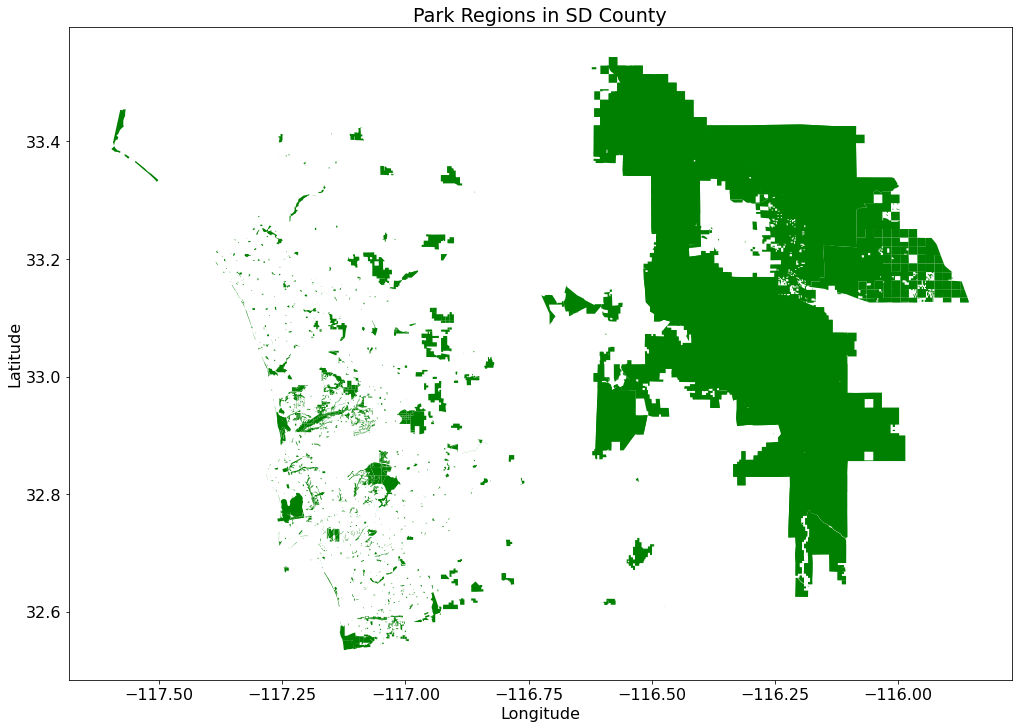

In [693]:
plt.rcParams.update({'font.size': 16})
fig, ax1 = plt.subplots(figsize=(25,12))
plt.title("Park Regions in SD County")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
parks_geo.plot(ax=ax1, color='green')
plt.show()

There looks like to be some very big parks towards the east (right) and a lot of scattered smaller parks to the west (left)

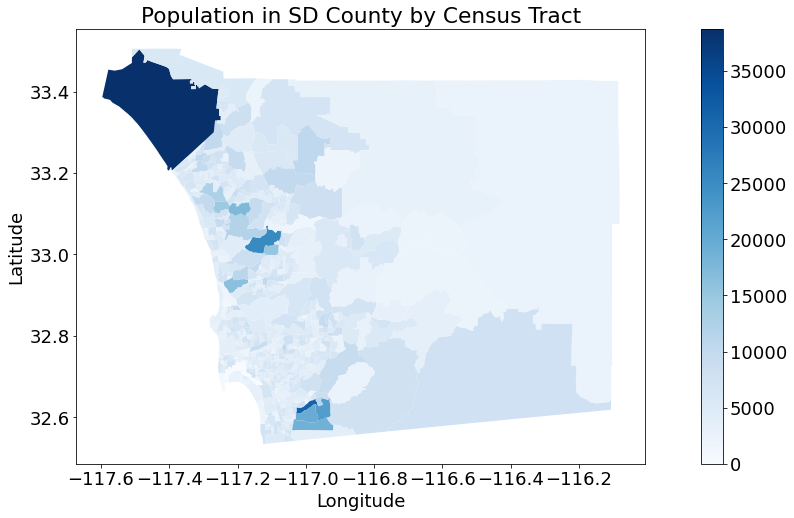

In [694]:
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(20,8))
plt.title("Population in SD County by Census Tract")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population.plot(ax=ax1, column='Total Population', cmap='Blues', legend=True)
plt.show()

From this, it appears that SD county is densely populated towards a few regions with also a lot of people living in the north west, other than the top left census tract being rather larger than most and with a lot of population, nothing is out of the ordinary here

In [695]:
# lets look at the crime data we saved earlier
sdpd_crime_df = pd.read_csv("data/sdpd_crime_data.csv")
sdpd_crime_df.head()

,date_time,beat,priority,address,latitude,longitude
0,2019-01-01 00:00:01,441,1,"3800 NATIONAL AVE, San Diego, CA, USA",-117.106044,32.696084
1,2019-01-01 00:00:04,321,2,"6500 REFLECTION DR, San Diego, CA, USA",-117.107681,32.792343
2,2019-01-01 00:00:09,523,2,"0 6TH AVE, San Diego, CA, USA",-117.162773,32.717420
3,2019-01-01 00:00:19,511,1,"0 VESTA ST, San Diego, CA, USA",-117.117332,32.683479
4,2019-01-01 00:00:31,523,4,"0 4TH AVE, San Diego, CA, USA",-117.162773,32.717420


This crime data can't really be plotted by itself since it is just a bunch of coordinates. So we need to convert the latitude and longitude to shapely point data so it can be plotted together with our other geographic data.

In [696]:
# generate the Points objects and create a new geo dataframe to replace our current crime dataframe
sdpd_crime_pts = [Point(x, y) for x, y in zip(sdpd_crime_df['latitude'], sdpd_crime_df['longitude']) ]
sdpd_crime_df = gpd.GeoDataFrame(sdpd_crime_df, geometry = sdpd_crime_pts)

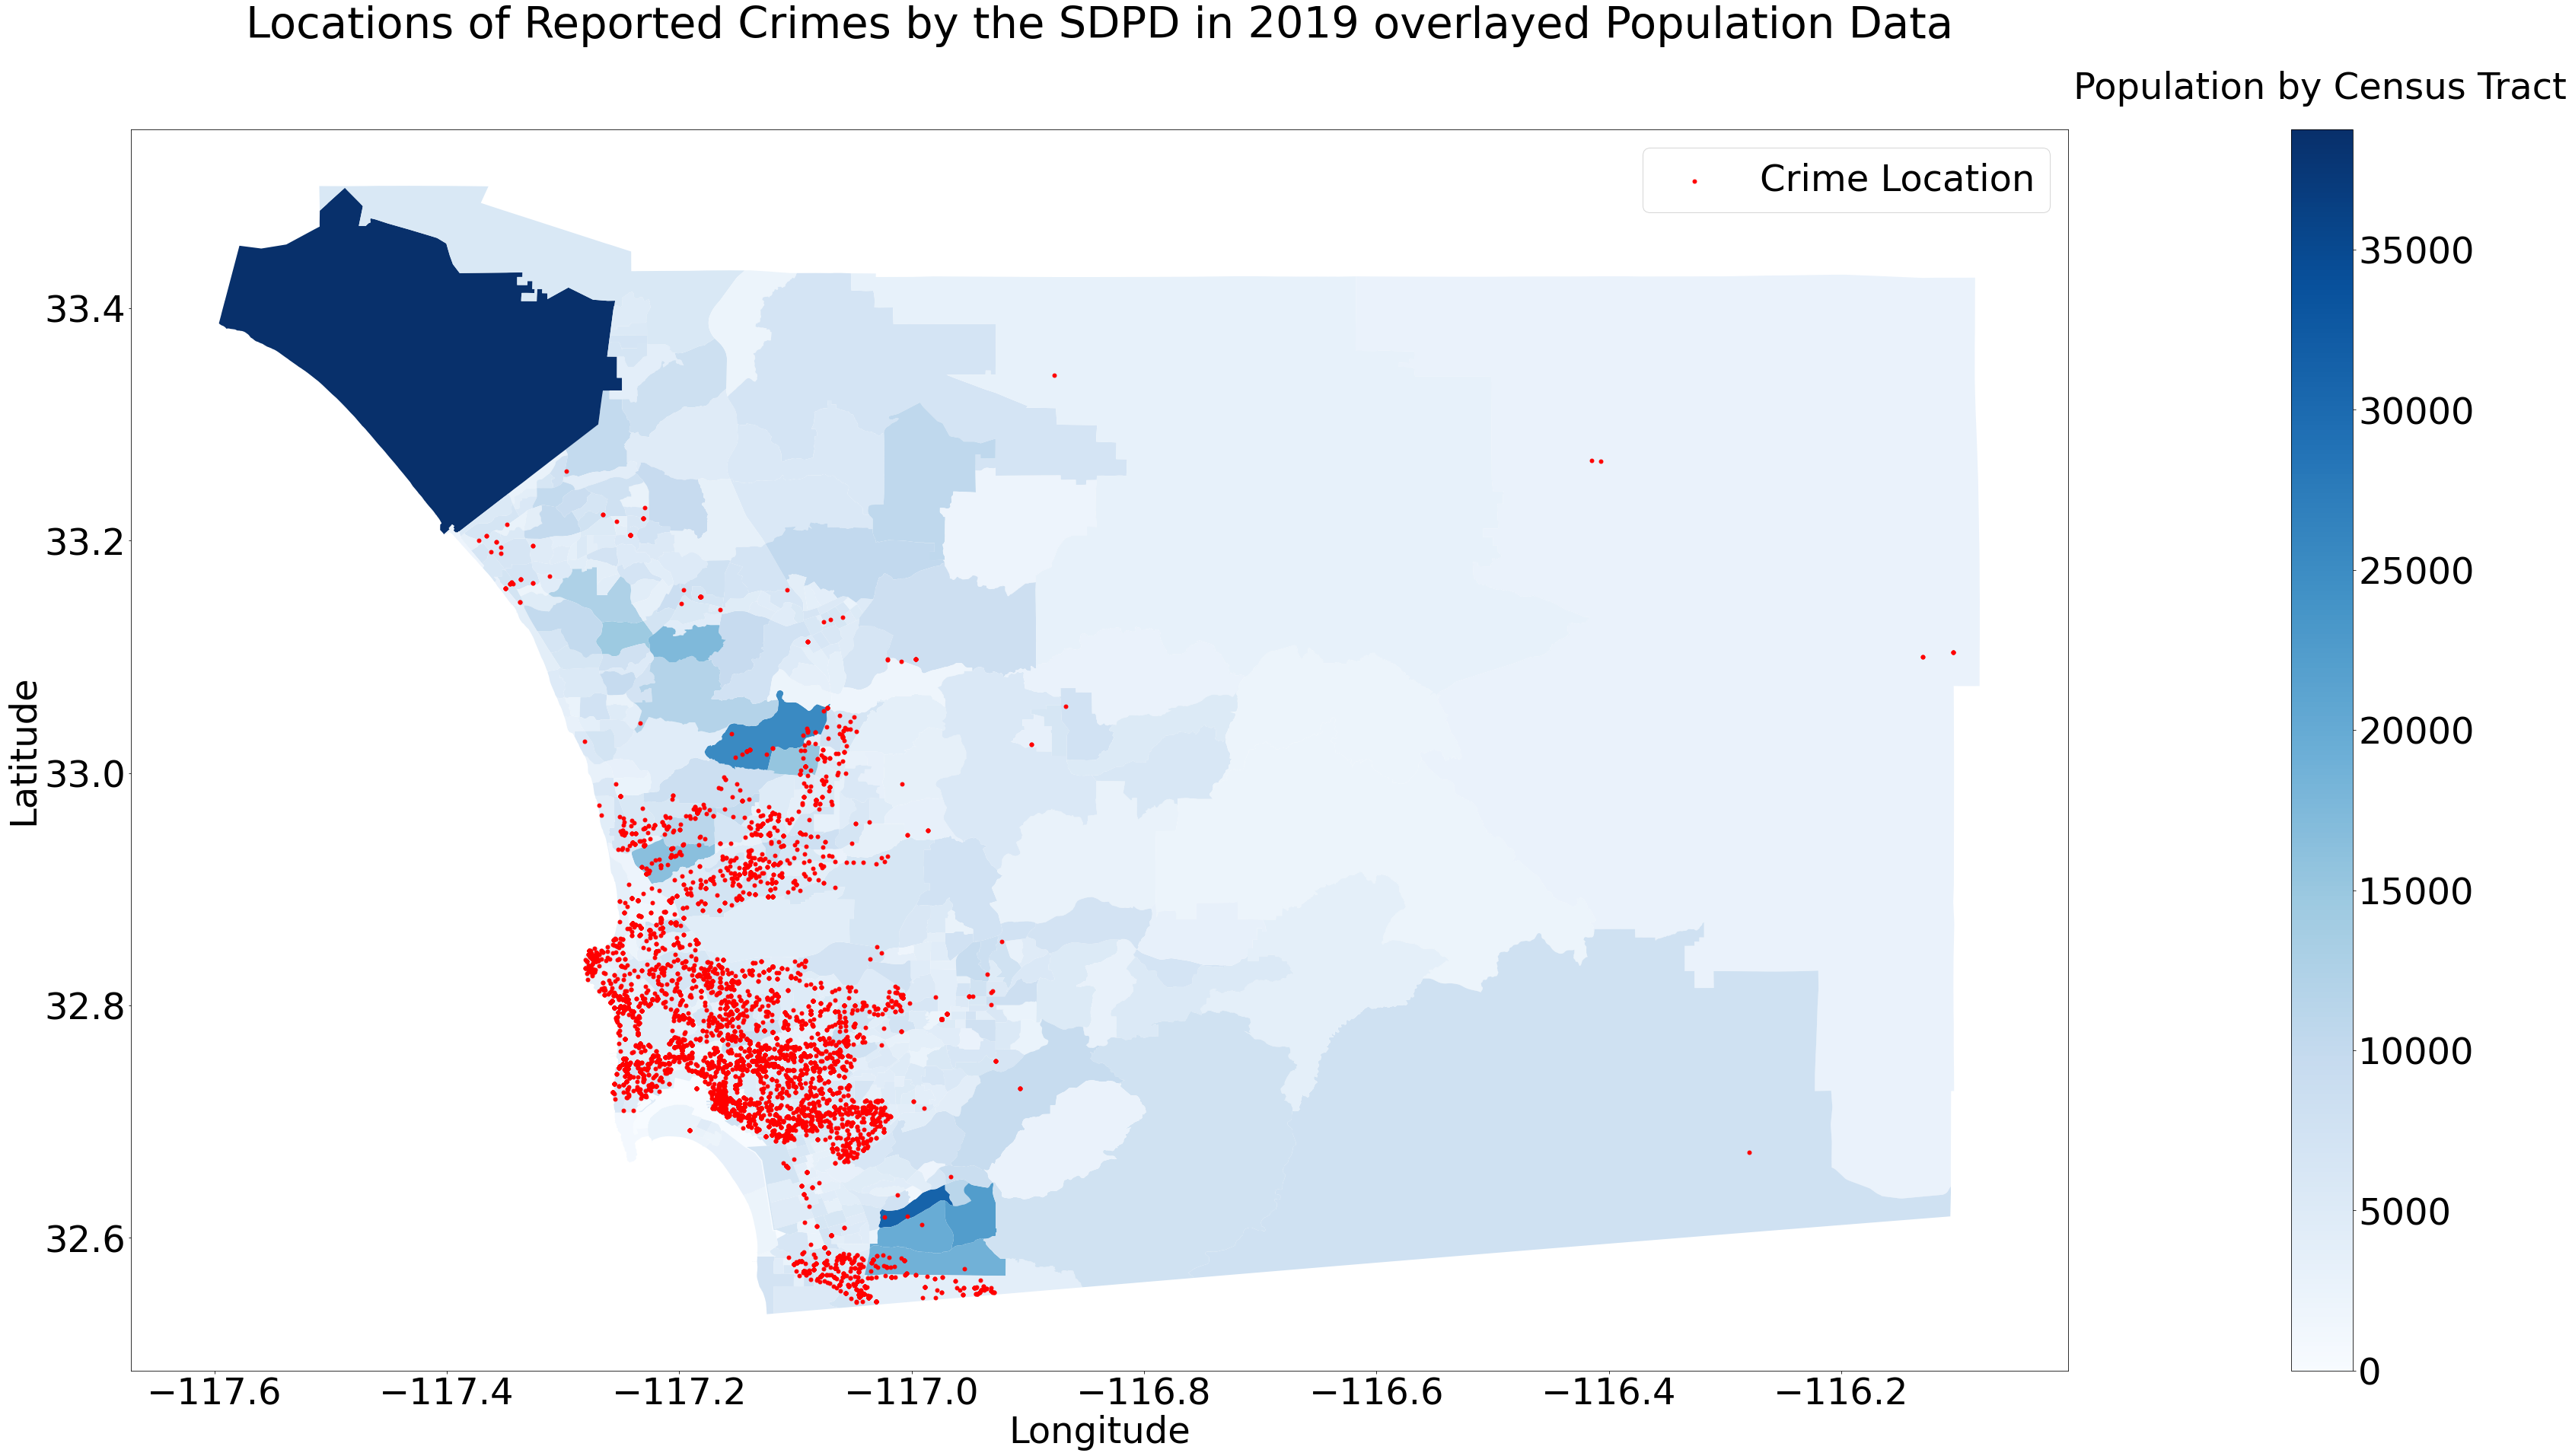

In [698]:
plt.rcParams.update({'font.size': 48})
fig, ax1 = plt.subplots(figsize=(105, 30))
plt.title("Locations of Reported Crimes by the SDPD in 2019 overlayed Population Data", pad=120)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population.plot(ax=ax1, column='Total Population', cmap='Blues', legend=True)
sdpd_crime_df.plot(ax=ax1, marker='o', color='red', markersize=24, label="Crime Location")
plt.text(-116.00,33.58, "Population by Census Tract")
plt.legend()
plt.show()

We see that noticeably, it appears majority of crimes are in the lower left region of the SD county, however the crime data provided is limited in scope by their jurisdiction as defined by the pd beats data, so we can only limit our analysis to the SDPD jurisdiction.

Let's look at the boundary of which the SDPD operates overlayed the crime data over the map of SD county to get a sense of the scope we have

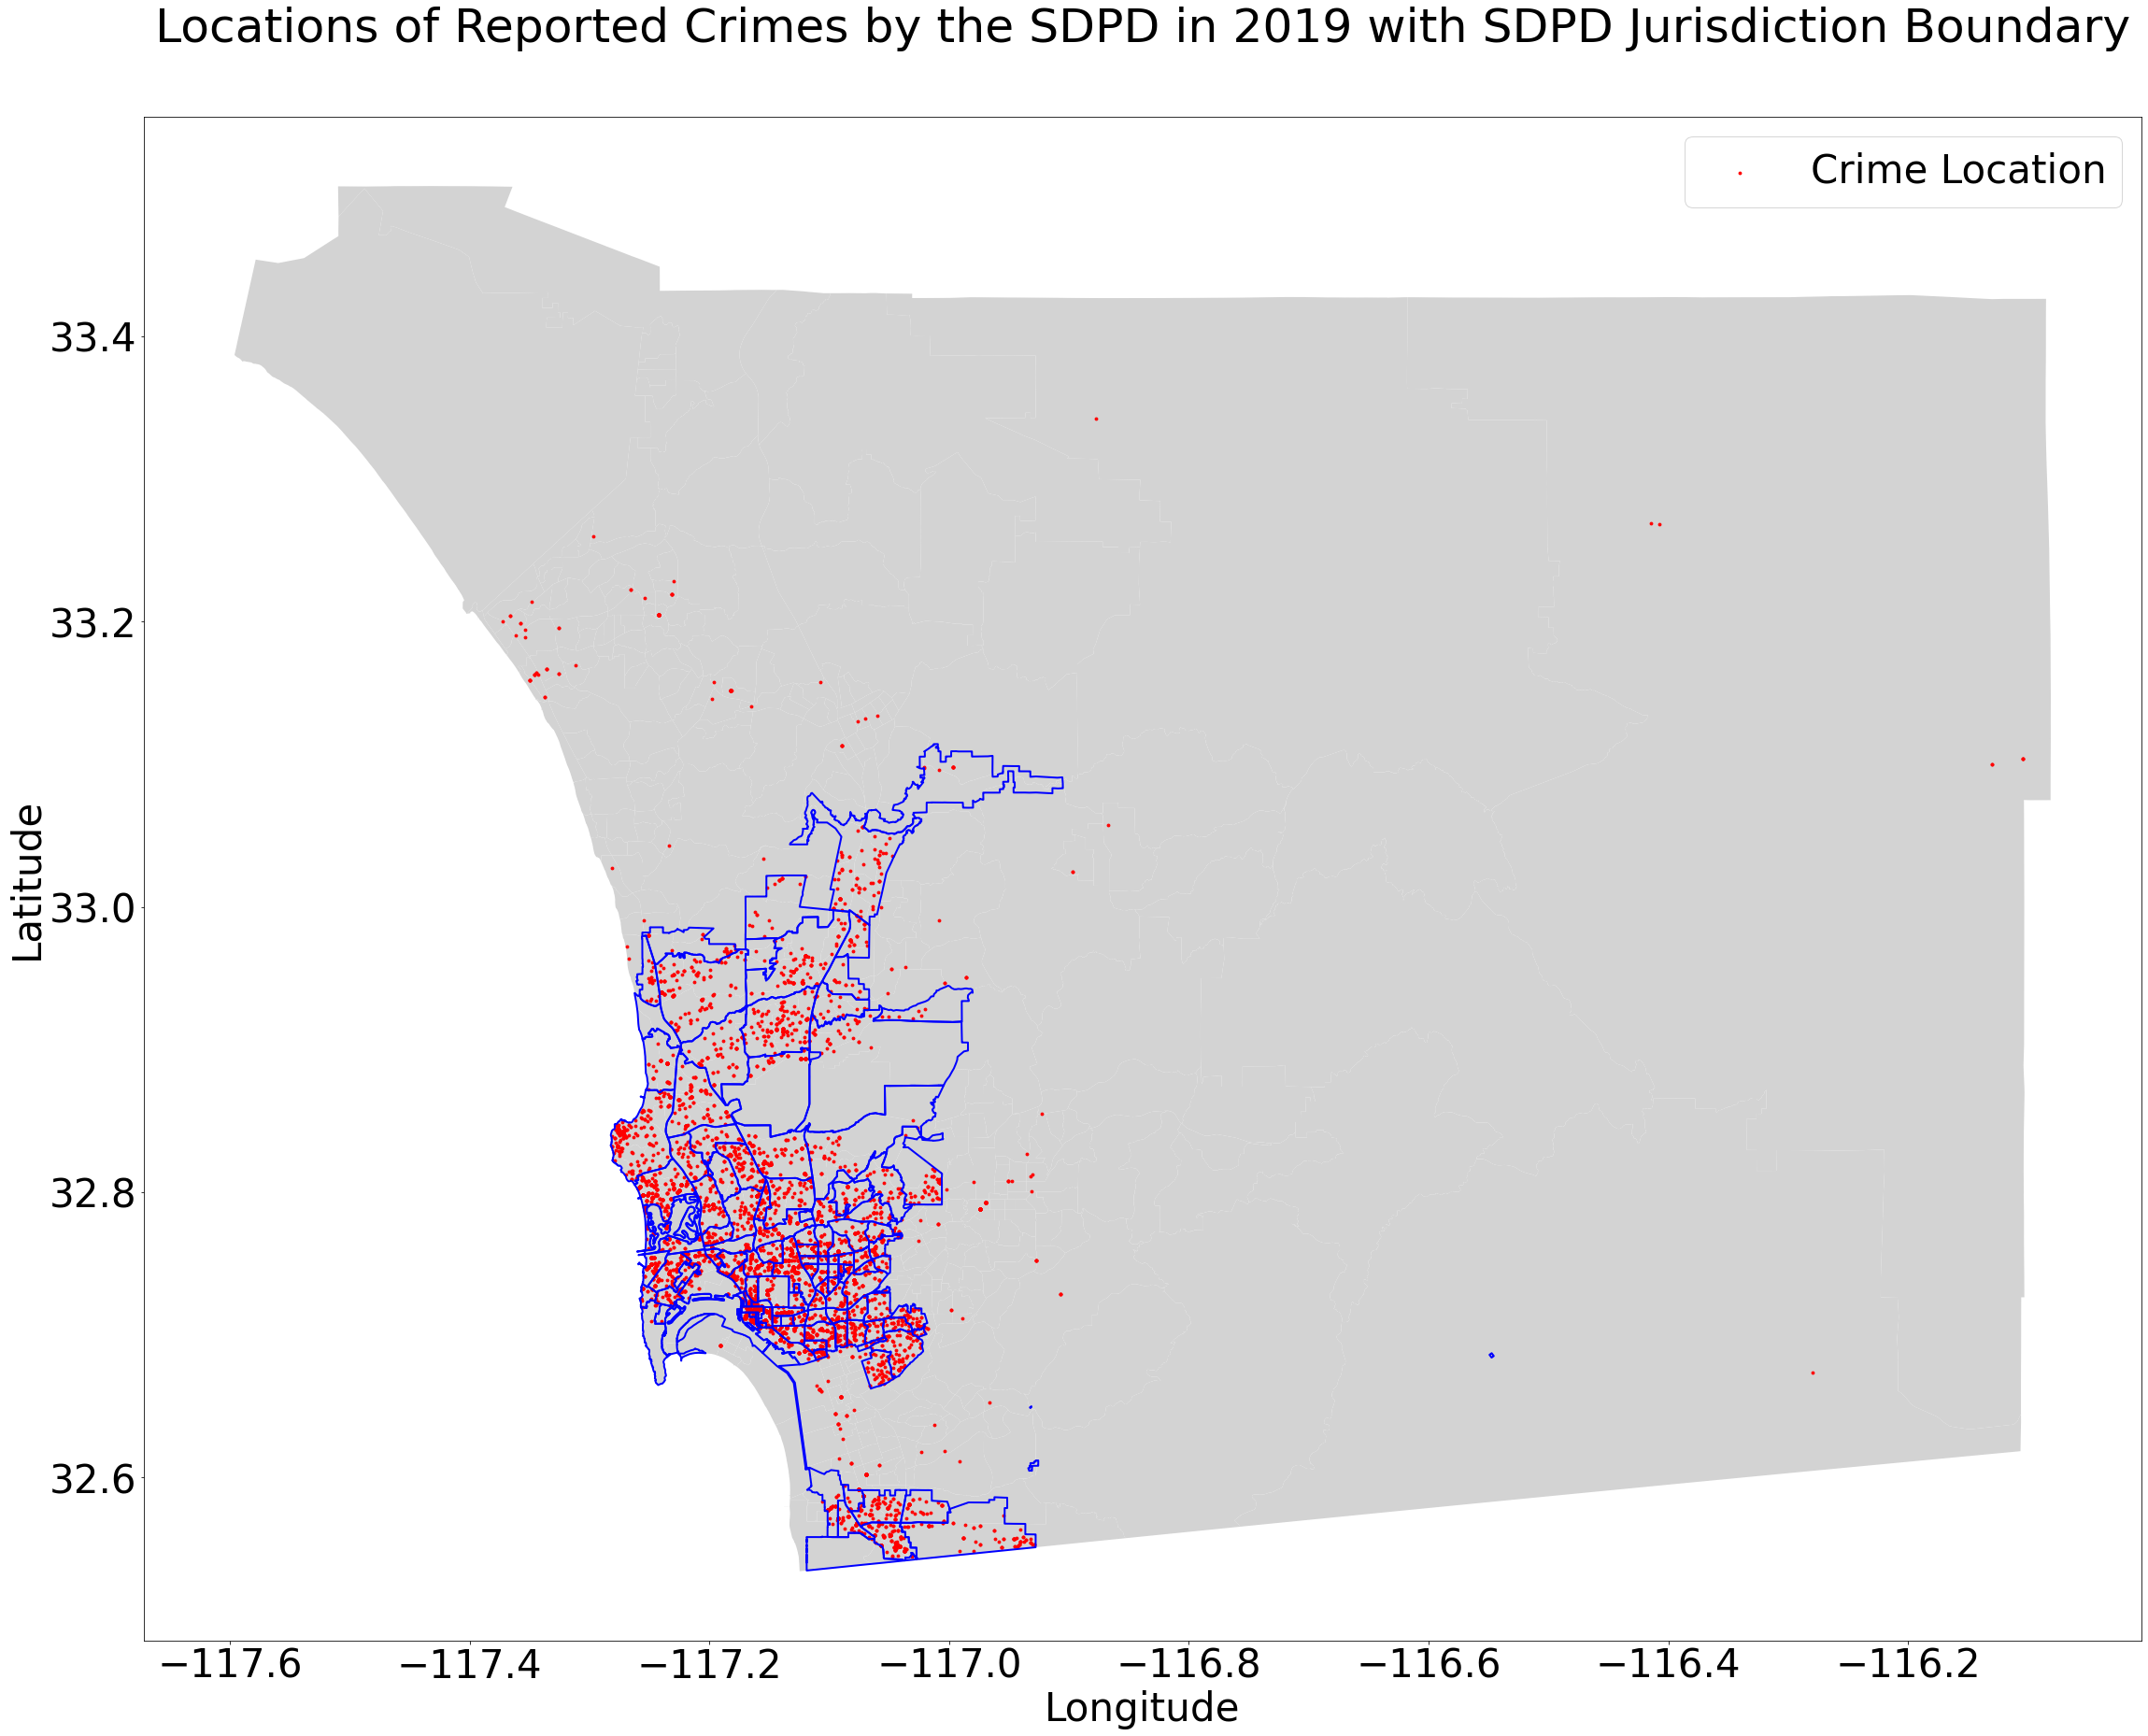

In [699]:
plt.rcParams.update({'font.size': 42})
fig, ax1 = plt.subplots(figsize=(105, 30))
plt.title("Locations of Reported Crimes by the SDPD in 2019 with SDPD Jurisdiction Boundary", pad=80)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population.plot(ax=ax1, color='lightgrey')
sdpd_crime_df.plot(ax=ax1, marker='o', color='red', markersize=8, label="Crime Location")
pd_beats_df.boundary.plot(ax=ax1, color='blue', linewidth=2)
ax1.legend()

plt.show()

From this, we see a clear reason why most reported crimes are clustered to the southern west counties, and this is because the SDPD do not handle any reports outside of these regions usually. There are some outliers however, which we  can check here:

In [137]:
def crime_is_not_in_SDPD_jurisdiction(row):
    for g in pd_beats_df['geometry']:
        if row['geometry'].within(g):
            return False
    return True
# count the number of crimes outside of jurisdiction
outside_of_jurisdiction_count = len(sdpd_crime_df[sdpd_crime_df.apply(crime_is_not_in_SDPD_jurisdiction, axis=1)])
print("{}, which is {}% of crimes are outside of jurisdiction".format(outside_of_jurisdiction_count, 100 *outside_of_jurisdiction_count / len(sdpd_crime_df)))

442, which is 4.56140350877193% of crimes are outside of jurisdiction


With this in mind, any data analysis of parks outside this jurisdiction area will likely be sub-optimal and easily subject to noise and random error due to only 442, 4.56% of the crimes reported being outside. Thus, we will have to clean our data and constrict future analysis to just the areas of which the SDPD are active and handling reports of crimes. We will do this by removing all census tracts that don't intersect enough with a SDPD beat and also remove all parks that don't intersect enough with a SDPD beat from our data. Moreover, we can remove the outlier crime report points that are out of jurisdiction as we are limiting our scope now

In [312]:
# create a combined SDPD jurisdiction region for faster computation in next cell
sdpd_jurisdiction_area = cascaded_union(pd_beats_df['geometry'])

In [320]:
# we say a region is in SDPD jurisdiction if at least 10% of the region is intersecting with a SDPD beat region
def is_in_SDPD_jurisdiction(row):
    test_shape = cascaded_union([row['geometry'], sdpd_jurisdiction_area])
    if row['geometry'].area + sdpd_jurisdiction_area.area - test_shape.area >= 0.1 * row['geometry'].area:
        return True
    return False
def crime_is_in_SDPD_jurisdiction(row):
    for g in pd_beats_df['geometry']:
        if row['geometry'].within(g):
            return True
    return False
census_tracts_with_population_constricted = census_tracts_with_population[census_tracts_with_population.apply(is_in_SDPD_jurisdiction, axis=1)]
parks_geo_constricted = parks_geo[parks_geo.apply(is_in_SDPD_jurisdiction, axis=1)]
sdpd_crime_df_constricted = sdpd_crime_df[sdpd_crime_df.apply(crime_is_in_SDPD_jurisdiction, axis=1)]

We can now visualize the region of SD county that is in the proper scope and confirm that we limited the SD county geography data to just the SDPD jurisdiction

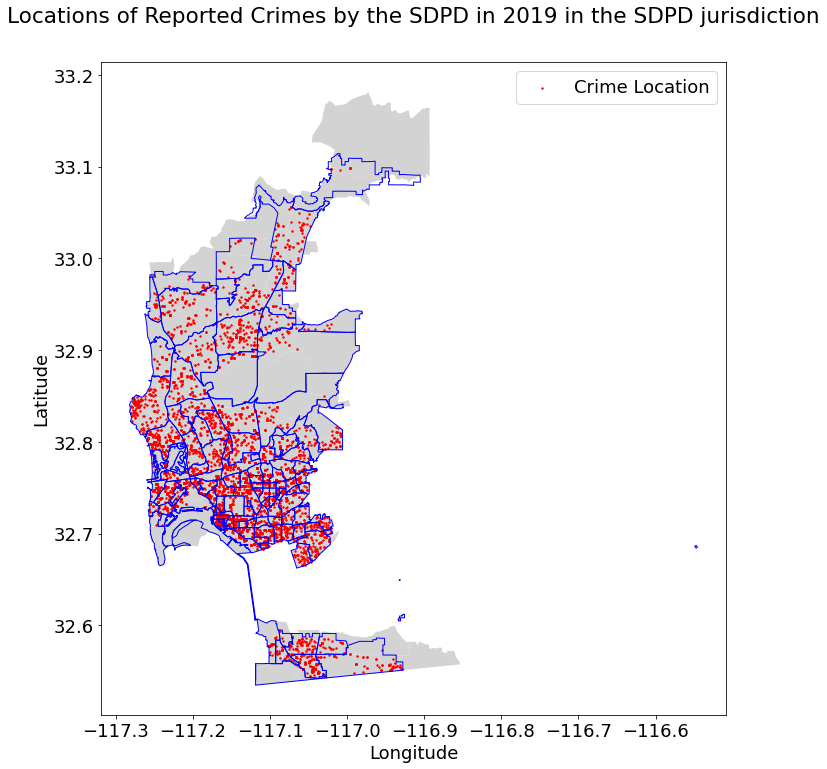

In [701]:
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(30, 12))
plt.title("Locations of Reported Crimes by the SDPD in 2019 in the SDPD jurisdiction", pad=40)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population_constricted.plot(ax=ax1, color='lightgrey')
sdpd_crime_df_constricted.plot(ax=ax1, marker='o', color='red', markersize=2, label="Crime Location")
pd_beats_df.boundary.plot(ax=ax1, color='blue', linewidth=1)
plt.legend()
plt.show()

We can now also visualize the parks that are covered by the SDPD and the crimes relative to them

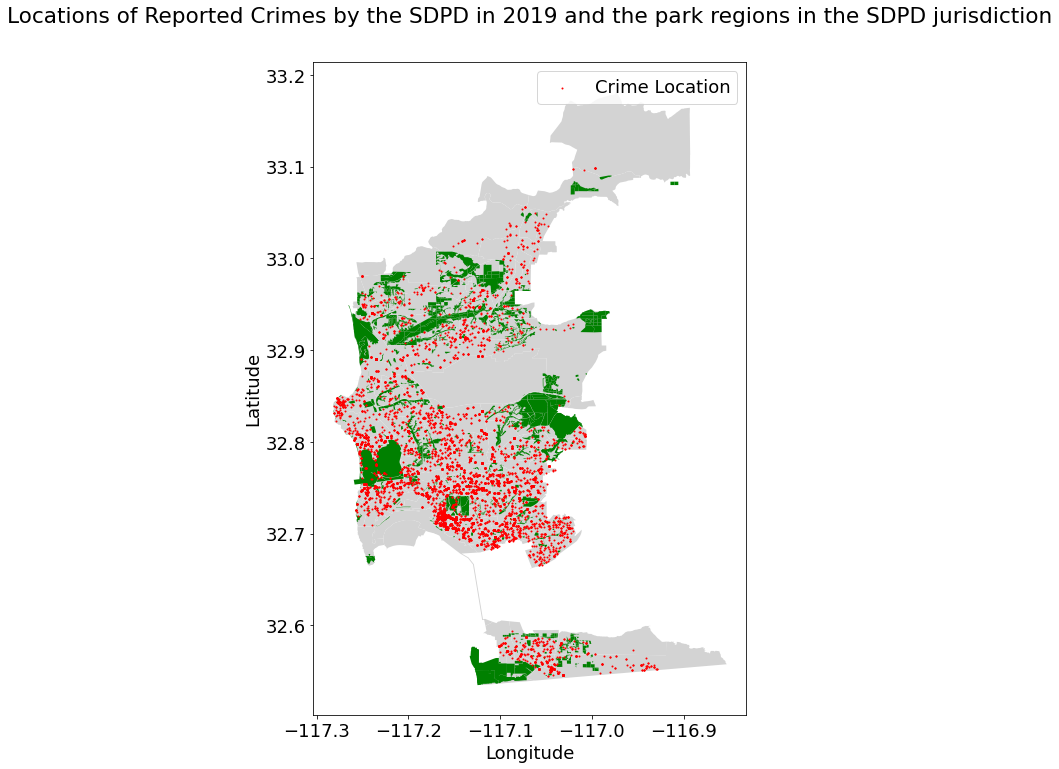

In [520]:
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(105,12))
plt.title("Locations of Reported Crimes by the SDPD in 2019 and the park regions in the SDPD jurisdiction", pad=40)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population_constricted.plot(ax=ax1, color='lightgrey')
parks_geo_constricted.plot(ax=ax1, color='green', linewidth=2, label="Park Region")
sdpd_crime_df_constricted.plot(ax=ax1, marker='o', color='red', markersize=1, label="Crime Location")
plt.legend()
plt.show()

As we removed entries, final bit of data cleaning is to reset the indices and then save the datasets for the future

In [361]:
census_tracts_with_population_constricted = census_tracts_with_population_constricted.reset_index()
census_tracts_with_population_constricted = census_tracts_with_population_constricted.drop(columns=['index'])

sdpd_crime_df_constricted = sdpd_crime_df_constricted.reset_index()
sdpd_crime_df_constricted = sdpd_crime_df_constricted.drop(columns=['index'])

parks_geo_constricted = parks_geo_constricted.reset_index()
parks_geo_constricted = parks_geo_constricted.drop(columns=['index'])

In [700]:
# save our datasets so we don't have to run all the cleaning code again
with open('data/parks_geo_constricted.json', 'w') as f:
    f.write(parks_geo_constricted.to_json())
with open('data/census_tracts_with_population_constricted.json', 'w') as f:
    f.write(census_tracts_with_population_constricted.to_json())
with open('data/sdpd_crime_df_constricted.json', 'w') as f:
    f.write(sdpd_crime_df_constricted.to_json())

We now have 3 geographical datasets: `census_tracts_with_population_constricted`, `sdpd_crime_df_constricted`, and `parks_geo_constricted`, all cleaned out and ready to use

# Data Analysis & Results

I hypothesize that parks have lower amounts of crime in the neighboring areas compared to areas without nearby parks. Parks come with mental and physical health benefits that can help deter the likelihood of future crime. Moreover, with more foot-traffic in these open spaces, parks will have more people which can deter crime as well.

To analyze the potential relationship between parks and crime, we ask if the distribution of crime locations within the SDPD jurisdiction is driven by the location of parks?

We will approach this in two possible directions using two metrics, distance to nearest crime, and number of crimes within approximately 1 kilometer.

## Part 1 - Nearest "Neighbor" / Crime Location Distance Metric
One way to operationalize this question is to compare the distance from parks to the nearest crime with the distance from parks to locations generated by a independent random process (IRP) or a weighted one accounting for other factors. We can then perform a hypothesis test using a independent samples t-test.

Using population data, we can map locations of reported crimes onto a population map by census tract. The following map shows that population might be driving the crimes more than parks and parks could have less of an effect, so when using an IRP to generate points, we will also generate a set of population weighted points as well to then test for

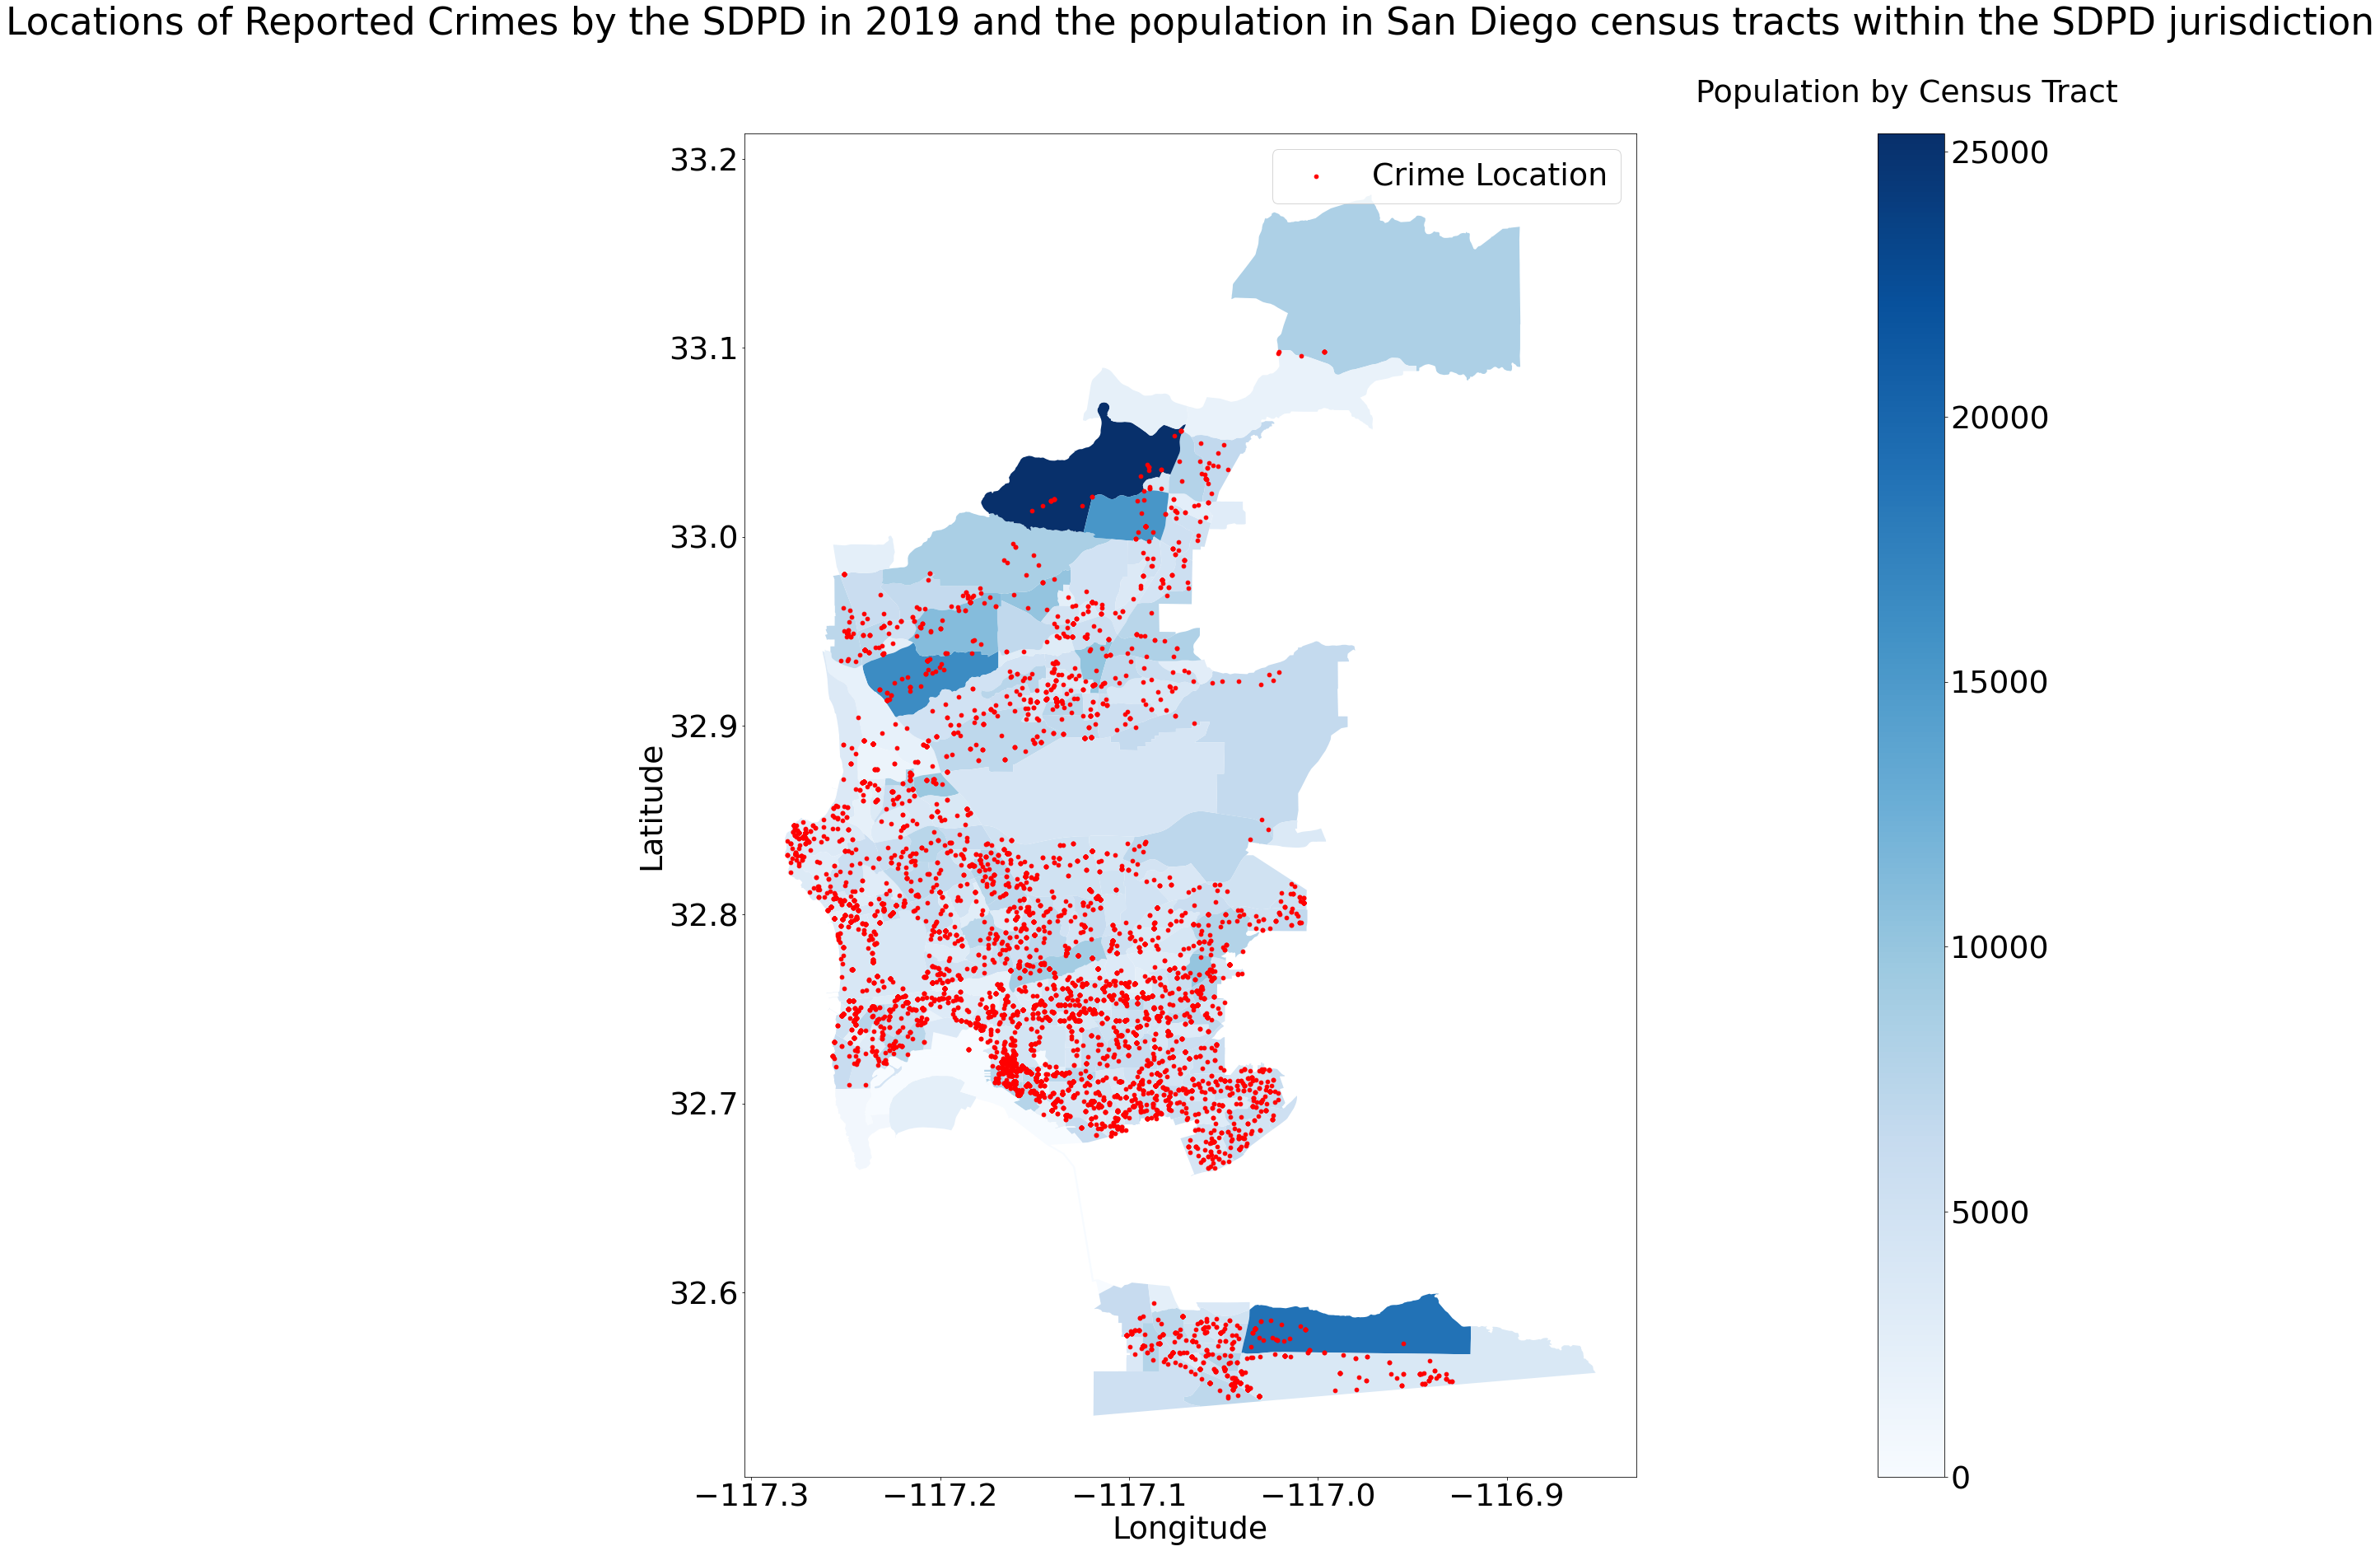

In [515]:
plt.rcParams.update({'font.size': 38})
fig, ax1 = plt.subplots(figsize=(105, 30))
plt.title("Locations of Reported Crimes by the SDPD in 2019 and the population in San Diego census tracts within the SDPD jurisdiction", pad=120)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population_constricted.plot(
    ax=ax1,
    column='Total Population', 
    cmap='Blues', 
    legend=True,
    label="population")
sdpd_crime_df_constricted.plot(ax=ax1, marker='o', color='red', markersize=22, label="Crime Location")
plt.text(-116.80,33.23, "Population by Census Tract")
plt.legend()

plt.show()

In [370]:
# initialize a dataframe for our analysis
park_nearest_distances = pd.DataFrame()
park_nearest_distances['observed_crime'] = np.zeros((len(parks_geo_constricted)))
park_nearest_distances['complete_random_locations'] = np.zeros((len(parks_geo_constricted)))
park_nearest_distances['population_weighted_locations'] = np.zeros((len(parks_geo_constricted)))

In [376]:
# create the region from which we will generate points on
sd_region = cascaded_union(list(census_tracts_with_population_constricted['geometry']))

In [377]:
def generate_random_points_within_polygon(num, polygon):
    min_x, min_y, max_x, max_y = polygon.bounds
    pts = []
    while len(pts) < num:
        random_x, random_y = np.random.uniform(min_x, max_x, size=(1,)), np.random.uniform(min_y, max_y, size=(1,))
        pt = Point(random_x, random_y)
        if polygon.contains(pt):
            pts.append(pt)
    return pts

In [381]:
count = len(sdpd_crime_df)
irp_pts = generate_random_points_within_polygon(count, sd_region)
temp_df = pd.DataFrame(np.zeros((count,)))
# create the geo dataframe with the IRP generated points
irp_geo_df = gpd.GeoDataFrame(temp_df, geometry = irp_pts)

In [538]:
# to generate population weighted points, we can calculate the relative percentage of random points that should be in
# each census tract region. Then pick a region with probability equal to the percentage calculated, and then
# pick a random point in that region
def generate_population_weighted_points(num, population_data):
    total = population_data['Total Population'].sum()
    n = len(population_data)
    pts = []
    cumulative_percentages = np.zeros((n))
    cumulative_percentage = 0
    for i in range(n):
        tract = population_data.iloc[i]
        p = tract['Total Population'] / total
        cumulative_percentage += p
        cumulative_percentages[i] = cumulative_percentage
    
    # using the cumulative_percentages, we can randomly pick a number from [0, 1) and 
    # then find index of first percentage greater than the number, which now makes the pick a weighed random pick
    for i in range(num):
        rand = np.random.uniform()
        k = 0
        for p in cumulative_percentages:
            if p > rand:
                break
            k += 1
        # our weighted random chose the kth region, so we use the polygon describing the kth region to pick a point
        polygon = population_data.iloc[k]['geometry']
        generated_pts = generate_random_points_within_polygon(1, polygon)
        pts.append(generated_pts[0])
    return pts    

In [543]:
count = len(sdpd_crime_df)
weighted_irp_pts = generate_population_weighted_points(count, census_tracts_with_population_constricted)
temp_df = pd.DataFrame(np.zeros((count,)))
# create the geo dataframe with the weighted generated points
weighted_irp_geo_df = gpd.GeoDataFrame(temp_df, geometry = weighted_irp_pts)

To check, we visualize the population weighted generated points and see it looks reasonable and works, high density areas have more points clustered together, and high population areas have overall more points. We will use just the first 1000 random points as to not to clutter the visual

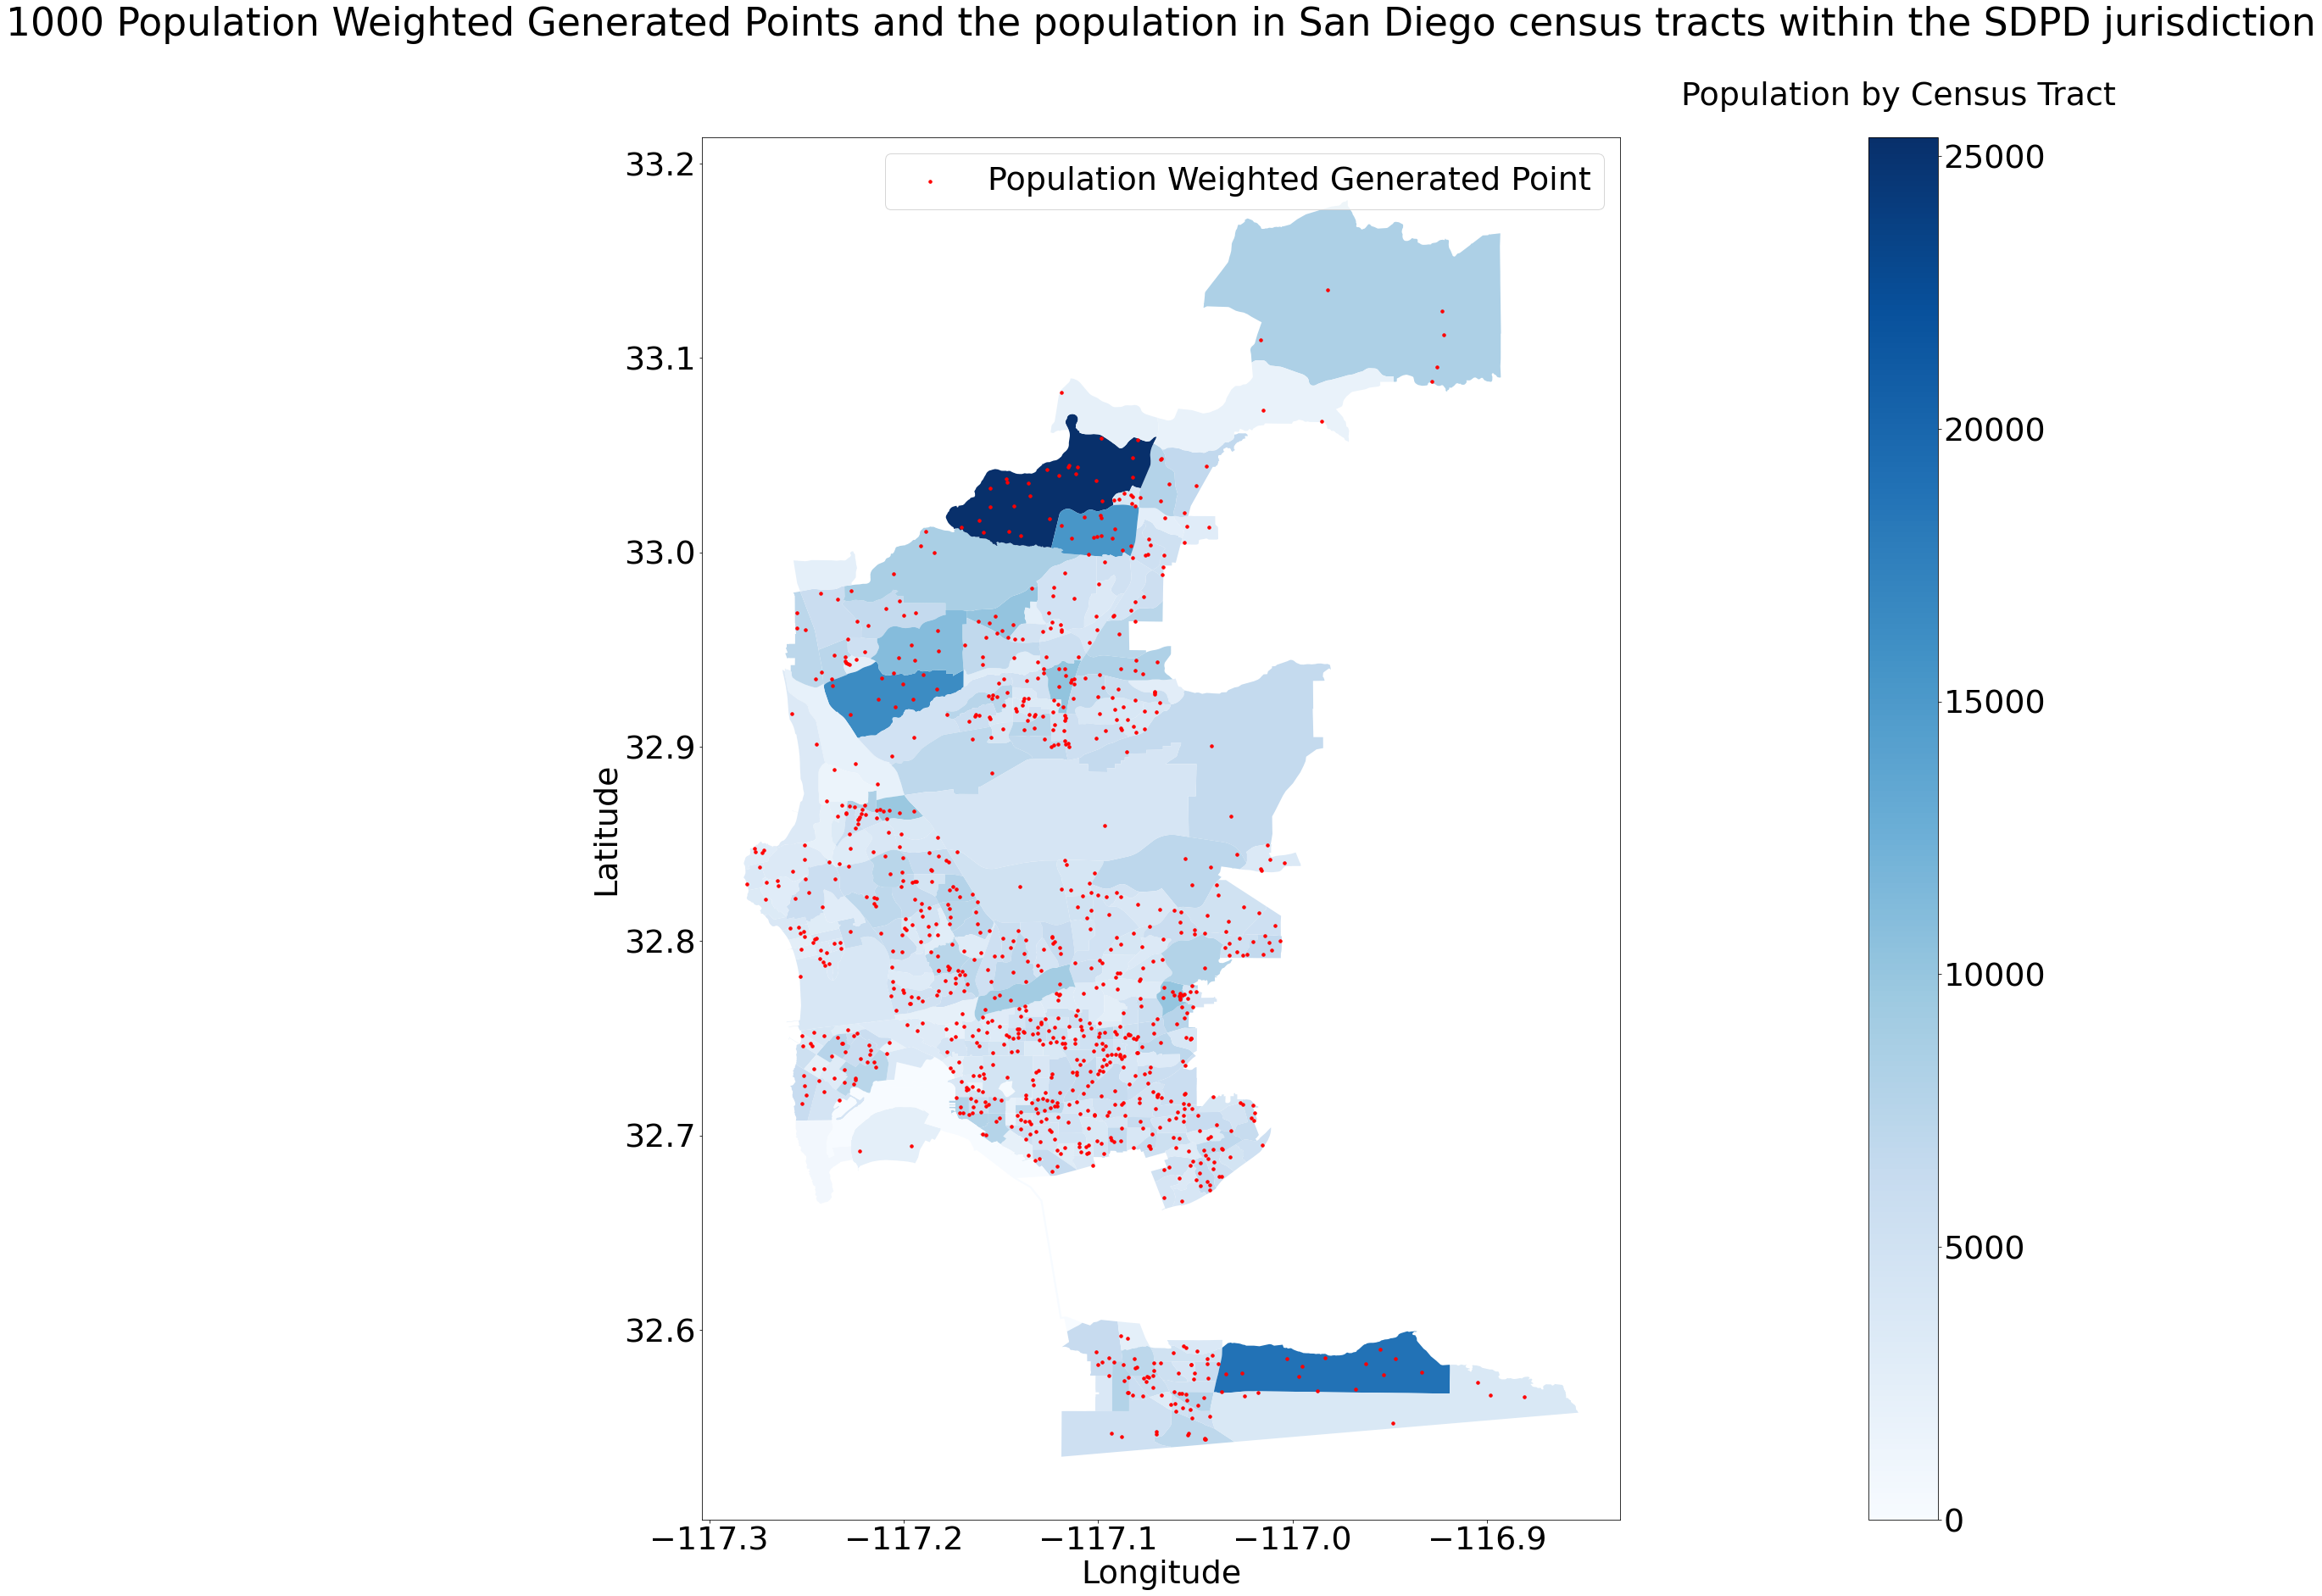

In [623]:
plt.rcParams.update({'font.size': 38})
fig, ax1 = plt.subplots(figsize=(105, 30))
plt.title("1000 Population Weighted Generated Points and the population in San Diego census tracts within the SDPD jurisdiction", pad=120)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
census_tracts_with_population_constricted.plot(
    ax=ax1,
    column='Total Population', 
    cmap='Blues', 
    legend=True,
    label="population")
plt.text(-116.80,33.23, "Population by Census Tract")
weighted_irp_geo_df[:1000].plot(ax=ax1, markersize=12, color='red', label="Population Weighted Generated Point")
plt.legend()

plt.show()

In [638]:
# calculate distance from park to nearest neighboring location in locations
def dist_to_nearest_neighbor(park, locations):
    closest = 9e9
    for g in locations['geometry']:
        closest = min(farthest, park['geometry'].distance(g))
    return closest

# calculate the distance of parks to the nearest location in given locations
def compute_distances(parks, locations):
    n = len(parks)
    distances = np.zeros((n))
    for i in range(n):
        park = parks.iloc[i]
        d = dist_to_nearest_neighbor(park, locations)
        distances[i] = d
        if i % 10 == 0:
            print(i)
    return distances

In [383]:
# calculate the distances from parks to observed crime locations
observed_distances = compute_distances(parks_geo_constricted, sdpd_crime_df_constricted)

In [386]:
# calculate the distances from parks to locations generated by an IRP
irp_distances = compute_distances(parks_geo_constricted, irp_geo_df)

In [557]:
# calculate the distances from parks to locations generated by an IRP weighted to follow the population distribution
pop_weighted_distances = compute_distances(parks_geo_constricted, weighted_irp_geo_df)

In [558]:
# store the distances
park_nearest_distances['observed_crime'] = observed_distances
park_nearest_distances['complete_random_locations'] = irp_distances
park_nearest_distances['population_weighted_locations'] = pop_weighted_distances

We can quickly look at the distributions of these distances from parks to nearest crime location, randomly generated point, and population weighted generated points to get a sense of what the distances are like

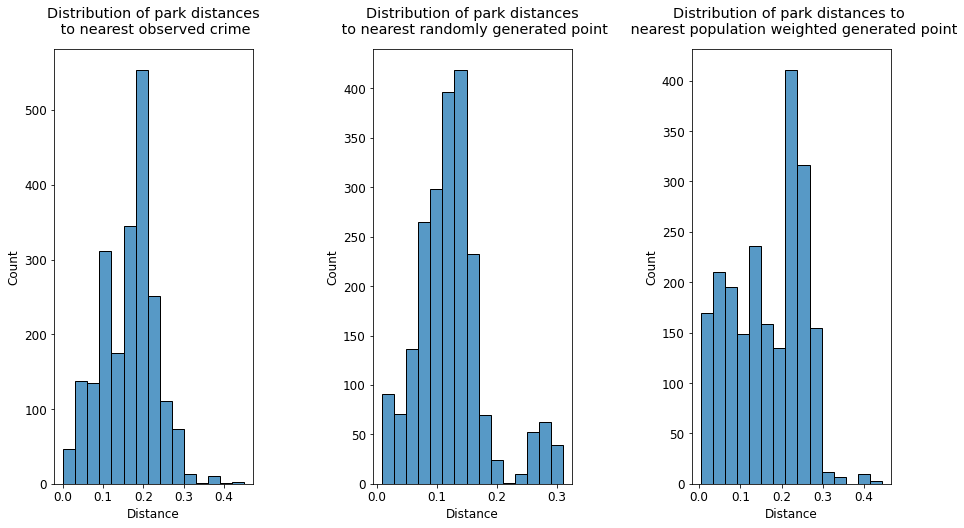

In [608]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 3, figsize=(15,8))

plt.subplots_adjust(wspace=0.6)
for i in range(3):
    axes[i].set_xlabel("Distance")

axes[0].set_title("Distribution of park distances\n to nearest observed crime", pad=15)
sns.histplot(park_nearest_distances['observed_crime'], bins=15, ax=axes[0])
axes[1].set_title("Distribution of park distances\n to nearest randomly generated point", pad=15)
sns.histplot(park_nearest_distances['complete_random_locations'], bins=15,ax=axes[1])
axes[2].set_title("Distribution of park distances to \n nearest population weighted generated point", pad=15)
sns.histplot(park_nearest_distances['population_weighted_locations'], bins=15,ax=axes[2])
plt.show()

We now perform independent samples t-test to see if there really is a difference between how far crimes are from parks compared to what we might expect them to be.

In [609]:
# compare observed crimes to completely random locations
scipy.stats.ttest_ind(park_nearest_distances['observed_crime'], park_nearest_distances['complete_random_locations'])

Ttest_indResult(statistic=21.225211658978775, pvalue=3.3743691309346546e-95)

In [610]:
# compare observed crimes to population weighted locations
scipy.stats.ttest_ind(park_nearest_distances['observed_crime'], park_nearest_distances['population_weighted_locations'])


Ttest_indResult(statistic=-0.4855384312954443, pvalue=0.6273190131296575)

In [616]:
print("Median distances for \nObserved Crime {}\nRandom Locations {}\nPopulation Weighted Locations {} ".format(park_nearest_distances['observed_crime'].median(), 
park_nearest_distances['complete_random_locations'].median(),
park_nearest_distances['population_weighted_locations'].median()))

Median distances for 
Observed Crime 0.17415430558703934
Random Locations 0.12045043603027923
Population Weighted Locations 0.1734100622365026 


When comparing our distances from park to nearest crime and park to nearest randomly generated location, our p-value is very small and much less than an alpha of 0.05. However, when comparing our distances from park to nearest crime and park to nearest population weighted location, our p-value is 0.627, which is greater than an alpha of 0.05. 


Assuming that locations and number of crimes are primarily driven by population, then this indicates that we cannot conclude if there is any true effect of parks on crime using the measurement of distance to nearest location.

## Part 2 - Number of Crimes within Radius of Park Metric
Another way to operationalize our guiding question of whether there is a driving effect of Parks is to instead count the number of crimes near the parks. 

This is likely a better metric than part 1 as using just the distance to the nearest crime discounts a lot of other data like the number of crimes that are far away or number of crimes that are close but just farther than the nearest crime.

Here, we can reuse our generated points from a completely random and a population weighted distribution and just change the function we apply to our data

In [642]:
def number_of_locations_in_radius(park, locations):
    count = 0
    for g in locations['geometry']:
        # 1e-2 degrees equates to approximately 1km
        # although exact is a bit due to how longitude and latitude work. Since our region is small, 
        # this approximation is good enough
        if park['geometry'].distance(g) <= 1e-2:
            count += 1
    return count 
# calculate the number of locations within a radius of all the parks
def compute_number_of_locations(parks, locations):
    n = len(parks)
    counts = np.zeros((n))
    for i in range(n):
        park = parks.iloc[i]
        count = number_of_locations_in_radius(park, locations)
        counts[i] = count
        if i % 10 == 0:
            print(i)
    return counts

In [643]:
# initialize a new dataframe for our analysis
park_count_nearby = pd.DataFrame()
park_count_nearby['observed_crime'] = np.zeros((len(parks_geo_constricted)))
park_count_nearby['complete_random_locations'] = np.zeros((len(parks_geo_constricted)))
park_count_nearby['population_weighted_locations'] = np.zeros((len(parks_geo_constricted)))

In [657]:
# compute the number of crimes, randomly generated points, and population weighted generated points are within a
# radius of ~1km of parks
num_of_locs_observed = compute_number_of_locations(parks_geo_constricted, sdpd_crime_df_constricted)

In [658]:
num_of_locs_random = compute_number_of_locations(parks_geo_constricted, irp_geo_df)

In [659]:
num_of_locs_pop_weighted = compute_number_of_locations(parks_geo_constricted, weighted_irp_geo_df)

In [660]:
# store results in dataframe
park_count_nearby['observed_crime'] = num_of_locs_observed
park_count_nearby['complete_random_locations'] = num_of_locs_random
park_count_nearby['population_weighted_locations'] = num_of_locs_pop_weighted

We can quickly look at the distributions of these numbers of crimes within ~1km radius of parks as observed, or generated

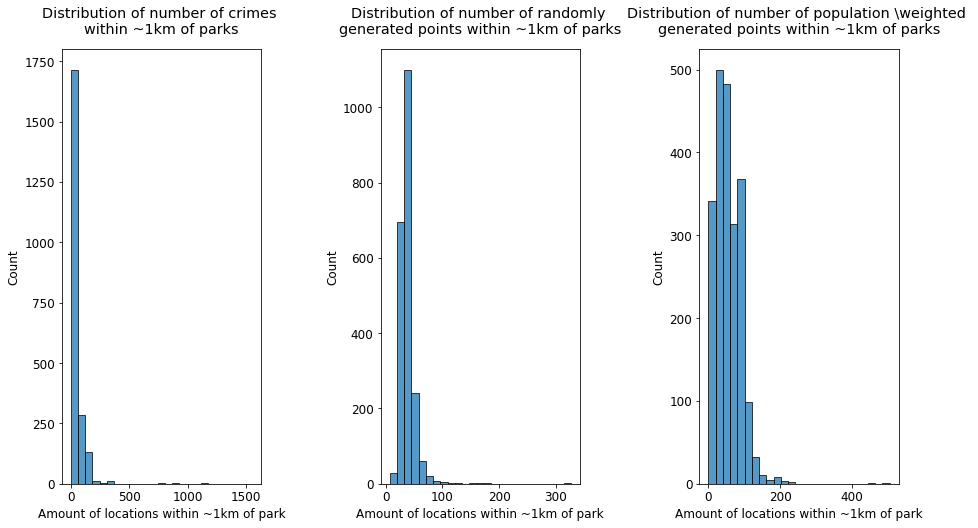

In [670]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 3, figsize=(15,8))

plt.subplots_adjust(wspace=0.6)
for i in range(3):
    axes[i].set_xlabel("Amount of locations within ~1km of park")

axes[0].set_title("Distribution of number of crimes \nwithin ~1km of parks", pad=15)
sns.histplot(park_count_nearby['observed_crime'], bins=25, ax=axes[0])
axes[1].set_title("Distribution of number of randomly \ngenerated points within ~1km of parks", pad=15)
sns.histplot(park_count_nearby['complete_random_locations'], bins=25,ax=axes[1])
axes[2].set_title("Distribution of number of population \weighted \ngenerated points within ~1km of parks", pad=15)
sns.histplot(park_count_nearby['population_weighted_locations'], bins=25,ax=axes[2])
plt.show()

In [671]:
# compare observed crimes to completely random locations
scipy.stats.ttest_ind(park_count_nearby['observed_crime'], park_count_nearby['complete_random_locations'])

Ttest_indResult(statistic=2.8260199321449075, pvalue=0.004734621115157902)

In [672]:
# compare observed crimes to completely random locations
scipy.stats.ttest_ind(park_count_nearby['observed_crime'], park_count_nearby['population_weighted_locations'])

Ttest_indResult(statistic=-6.002530795657436, pvalue=2.1015076928868963e-09)

In [673]:
print("Median counts for \nObserved Crime {}\nRandom Locations {}\nPopulation Weighted Locations {} ".format(park_count_nearby['observed_crime'].median(), 
park_count_nearby['complete_random_locations'].median(),
park_count_nearby['population_weighted_locations'].median()))

Median counts for 
Observed Crime 18.0
Random Locations 35.0
Population Weighted Locations 51.0 


From both independent samples t-tests, the p-values are less than 0.05, indicating that there is a statistically significant difference in the number of crimes observed within ~1km of parks compared to the number of locations as generated from a complete random or weighted population distribution within ~1km of parks.

This seems to indicate that even when considering the population distribution, there tends to be less crimes near parks than observed

# Ethics & Privacy

In regards to data reqired for this proposal, there are no human subjects nor is there any personally identifiable information as all the data is about locations of parks and crimes and the type of crimes as well as dates. Moreover, according to the providers of the police calls to service data, sensitive incidents such as "domestic violence, child abuse, suicide, sex crimes and stalking" are excluded.

All of this data is provided publiclly by the US Government through the census or the San Diego government through their data portal and have full permission to be used.

It is also important to note that the entire notebook and analysis is centered on San Diego only, in particular, the region over which the San Diego Police Department has jurisdiction over. Thus, the extent of this analysis should be limited to said scope and it's demographic in that scope and should not be extrapolated for analysis in other regions/cities which could have very different demographics and crime/park behaviors.

Furthermore, the park location data is on properties "managed by the City of San Diego Parks & Recreation Department" according to the source of the park location data. Thus, this analysis is biased towards public parks run by the City of San Diego and without consideration of private parks, can skew the analysis.

There can also be some bias towards less sensitive crimes as the data given does not include sensitive incidents and this can also skew the analysis. 

To handle the above issues, I will explicitly mention the proper scope of this analysis as well as mention some of the limitations that can pose potential issues such as how I only used a week's worth of crime data for analysis due to computation limits. I will also ensure to bring up the potential biases as well.

# Conclusion & Discussion

Overall, we conclude that from the data, there is likely some form of effect of public parks on crime in the areas under the jurisdiction of the SDPD and our hypothesis is true for that area. However, we don't have enough data to make any conclusions about public parks and crimes for the entire SD county and thus that was not analyzed.

We analyzed the potential relationship between locations of public parks and locations of crime through 2 metrics. 

The first metric was measuring the closest distance to a crime from a park and this indicated there wasn't much of an effect of parks once population distribution was taken into account when generating locations to form the null distribution of crime locations. However, this first metric is less effective and precise when there is a lot of data points as a lot of data has less influence over the result and so this could easily inprecise as explained earlier in the analysis.

Our second metric instead counts the number of crimes within a ~1km radius of parks, and showed that there was statistically significant less crimes near parks compared to the number of generated locations near parks based on a null distribution of crime locations. 

However, there are a number of limitations that have come up from the data to the analysis. 

The data itself is subject to biases. In particular, more sensitive crimes were not included by the SD government and there could be some bias towards less sensitive crimes for our conclusions. Moreover, due to computational limits, we could only use and process about a week's worth of crime data as getting coodinates of the crimes takes a long time and then processing that data also took up a lot of computational power. The week of data that was used may not fully represent how crime might occur in other weeks that might have holidays or different weather etc. Ideally, we would want data with the coordinates encoded already instead of just street addresses to enable spatial analysis.

Finally, our second metric used ~1km as the radius to then count the number of crimes near a park. For different radii, this would affect the results as well but due to time and computational constraints, we only show the results for 1km

While limited in scope, this analysis does indicate that public parks correlate with less crime nearby and shows that there is value in further investigating power of public parks in other areas and cities. There is a lot more data that could be used to provide deeper analysis into public parks such as foot-traffic, park sizes, and how they may help deter crime and this speaks to the potential for public parks.